In [1]:
from qiskit import IBMQ
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.10.0',
 'qiskit-aer': '0.3.2',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.13.0'}

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [3]:
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
import math

#Include our assertion function
from qiskit.compiler.assertion import classical_assertion, superposition_assertion, entanglement_assertion, calcSuccessrate

In [4]:
#we used ibmq_20_tokyo for our experiment, however, that backend has retired. We use the 5-qubit machine ibmqx2 
#as it has better connectivity than the available 20-qubit machines
device = provider.get_backend('ibmqx2')
backend_monitor(device)
device

ibmqx2
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 1
    backend_version: 2.0.1
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    max_shots: 8192
    allow_q_circuit: False
    description: 5 qubit device
    n_registers: 1
    backend_name: ibmqx2
    credits_required: True
    memory: True
    url: None
    allow_object_storage: True
    sample_name: sparrow
    online_date: 2018-11-06T05:00:00+00:00
    quantum_volume: 8
    allow_q_object: True
    max_experiments: 75
    conditional: False
    open_pulse: False
    coupling_map: [[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]]

Qubits [Name / Freq / T1 / T2 / U1 err / U2 err / U3 err / Readout err]
-----------------------------------------------------------------------
    Q0 / 5.28626 GHz / 61.07216 µs / 61.23455 µs / 0.0 / 0.00049 / 0.00098 / 0.0225
    Q1 / 5.23787 GHz / 52.82996

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
pi = math.pi
transQcList = []

In [6]:
def BVCircuit(bvCircuit, nbits, hiddenValue, qr, cr):
    for i in range(nbits):
        bvCircuit.h(qr[i])
    bvCircuit.x(qr[nbits])
    bvCircuit.h(qr[nbits])
    
    # Apply the inner-product oracle
    for j in range(nbits):
        if (hiddenValue & (1 << j)):
            bvCircuit.cx(qr[j], qr[nbits])
#        else:
#            bvCircuit.iden(qr[j])
            
    for i in range(nbits):
        bvCircuit.h(qr[i])
        
    for i in range(nbits):
        bvCircuit.measure(qr[i], cr[i])

In [7]:
qr = QuantumRegister(3)
# for recording the measurement on qr
cr = ClassicalRegister(2)

circuitName = "BV2"
circ = QuantumCircuit(qr, cr)
BVCircuit(circ, 2, 2, qr, cr)
trans_qc = transpile(circ, device)
print("BV2 size =",trans_qc.size(),"depth = ",trans_qc.depth(), "width = ",trans_qc.width(), "\n OPs =", trans_qc.count_ops(), "subcircuits =",trans_qc.num_tensor_factors())


#assertion
qr = QuantumRegister(3)
# for recording the measurement on qr
cr = ClassicalRegister(2)

circuitName = "BV2_assertion"
circ = QuantumCircuit(qr, cr)
BVCircuit(circ, 2, 2, qr, cr)
qubitList = [qr[2]]
phaseDict = {qr[2]:[pi/2, pi]}
superposition_assertion(circ, qubitList, phaseDict, flag = 1)
trans_qc_assert = transpile(circ, device)
print("BV2_assertion size =",trans_qc_assert.size(),"depth = ",trans_qc_assert.depth(), "width = ",trans_qc_assert.width(), "\n OPs =", trans_qc_assert.count_ops(), "subcircuits =",trans_qc_assert.num_tensor_factors())


BV2 size = 6 depth =  4 width =  7 
 OPs = OrderedDict([('u2', 2), ('measure', 2), ('u3', 1), ('cx', 1)]) subcircuits = 4
BV2_assertion size = 14 depth =  8 width =  8 
 OPs = OrderedDict([('u2', 6), ('cx', 3), ('measure', 3), ('u3', 1), ('u1', 1)]) subcircuits = 3


In [8]:
transQcList.append(trans_qc)
transQcList.append(trans_qc_assert)

In [12]:
#3bits
qr = QuantumRegister(4)
# for recording the measurement on qr
cr = ClassicalRegister(3)

circuitName = "BV3"
circ= QuantumCircuit(qr, cr)
BVCircuit(circ, 3, 6, qr, cr)
trans_qc = transpile(circ, device)
print("BV3 size =",trans_qc.size(),"depth = ",trans_qc.depth(), "width = ",trans_qc.width(), "\n OPs =", trans_qc.count_ops(), "subcircuits =",trans_qc.num_tensor_factors())


#assertion
qr = QuantumRegister(4)
# for recording the measurement on qr
cr = ClassicalRegister(3)

circuitName = "BV3_assertion"
circ = QuantumCircuit(qr, cr)
BVCircuit(circ, 3, 6, qr, cr)
qubitList = [qr[3]]
phaseDict = {qr[3]:[pi/2, pi]}
superposition_assertion(circ, qubitList, phaseDict, flag = 1)
trans_qc_assert = transpile(circ, device)
print("BV3_assertion size =",trans_qc_assert.size(),"depth = ",trans_qc_assert.depth(), "width = ",trans_qc_assert.width(), "\n OPs =", trans_qc_assert.count_ops(), "subcircuits =",trans_qc_assert.num_tensor_factors())


BV3 size = 16 depth =  8 width =  8 
 OPs = OrderedDict([('cx', 8), ('u2', 4), ('measure', 3), ('u3', 1), ('barrier', 1)]) subcircuits = 2
BV3_assertion size = 21 depth =  12 width =  9 
 OPs = OrderedDict([('u2', 8), ('cx', 7), ('measure', 4), ('u3', 1), ('u1', 1), ('barrier', 1)]) subcircuits = 2


In [13]:
transQcList.append(trans_qc)
transQcList.append(trans_qc_assert)

In [14]:
#BV5 with assertion requires 6 qubits, it does not fit on 5qubit machine ibmqx2
# #4bits
# qr = QuantumRegister(5)
# # for recording the measurement on qr
# cr = ClassicalRegister(4)

# circuitName = "BV4"
# circ = QuantumCircuit(qr, cr)
# BVCircuit(circ, 4, 14, qr, cr)
# trans_qc = transpile(circ, device, optimization_level = 3)
# transQcList.append(trans_qc)
# print("BV4 size =",trans_qc.size(),"depth = ",trans_qc.depth(), "width = ",trans_qc.width(), "\n OPs =", trans_qc.count_ops(), "subcircuits =",trans_qc.num_tensor_factors())


# #assertion
# qr = QuantumRegister(5)
# # for recording the measurement on qr
# cr = ClassicalRegister(4)

# circuitName = "BV4_assertion"
# circ = QuantumCircuit(qr, cr)
# BVCircuit(circ, 4, 14, qr, cr)
# qubitList = [qr[4]]
# phaseDict = {qr[4]:[pi/2, pi]}
# superposition_assertion(circ, qubitList, phaseDict, flag = 1)
# trans_qc = transpile(circ, device, optimization_level = 2)
# print("BV4_assertion size =",trans_qc.size(),"depth = ",trans_qc.depth(), "width = ",trans_qc.width(), "\n OPs =", trans_qc.count_ops(), "subcircuits =",trans_qc.num_tensor_factors())


In [15]:
shots = 8192
#execute the job on real device
job = execute(transQcList, backend=device, shots=shots)
job_monitor(job)
res = job.result()

Job Status: job has successfully run


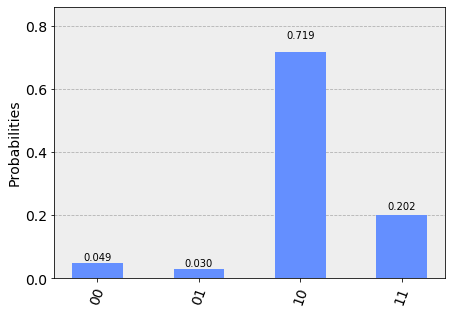

In [16]:
plot_histogram([res.get_counts(0)])

Success rate of BV2 without assertion

In [17]:
calcSuccessrate(res.get_counts(0), "10", 0)

total_count =  8192 success_count =  5886 success_rate =  71.8505859375 %


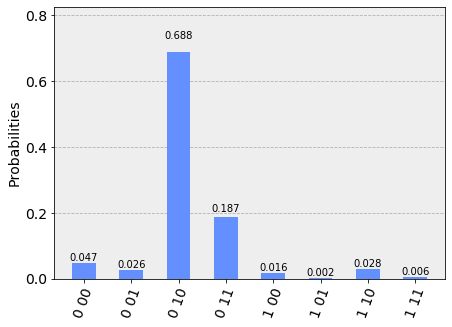

In [18]:
plot_histogram([res.get_counts(1)])

Success rate of BV2 with assertion

In [19]:
calcSuccessrate(res.get_counts(1), ["0 10"], 1)

total_count =  7768 success_count =  5632 success_rate =  72.50257466529351 %


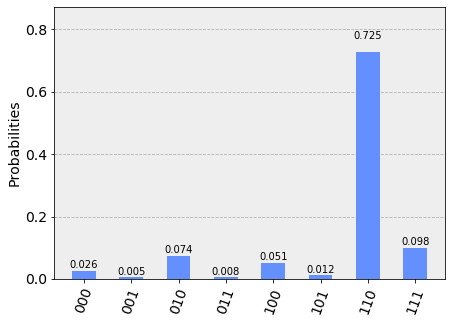

In [20]:
plot_histogram([res.get_counts(2)])

Success rate of BV3 without assertion

In [21]:
calcSuccessrate(res.get_counts(2), "110", 0)

total_count =  8192 success_count =  5942 success_rate =  72.5341796875 %


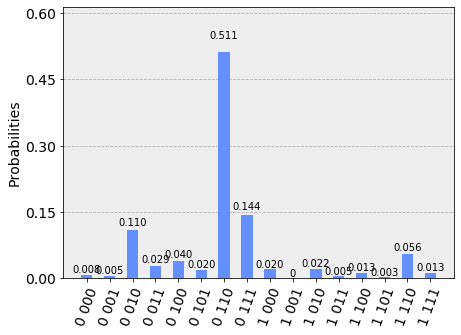

In [22]:
plot_histogram([res.get_counts(3)])

Success rate of BV3 with assertion

In [23]:
calcSuccessrate(res.get_counts(3), ["0 110"], 1)

total_count =  7107 success_count =  4190 success_rate =  58.95595891374701 %
